# Imports

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
)

from time import time
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (8, 4)})

# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](./data/CRISP-DM-BANK.pdf) for more information on the data and features.

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

From the paper, we have this quote:
>The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
df = pd.read_csv("./data/bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


To make the development faster, pick a random subset of the data

In [3]:
df = df.sample(frac=0.05, random_state=42)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2059 entries, 32884 to 25526
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2059 non-null   int64  
 1   job             2059 non-null   object 
 2   marital         2059 non-null   object 
 3   education       2059 non-null   object 
 4   default         2059 non-null   object 
 5   housing         2059 non-null   object 
 6   loan            2059 non-null   object 
 7   contact         2059 non-null   object 
 8   month           2059 non-null   object 
 9   day_of_week     2059 non-null   object 
 10  duration        2059 non-null   int64  
 11  campaign        2059 non-null   int64  
 12  pdays           2059 non-null   int64  
 13  previous        2059 non-null   int64  
 14  poutcome        2059 non-null   object 
 15  emp.var.rate    2059 non-null   float64
 16  cons.price.idx  2059 non-null   float64
 17  cons.conf.idx   2059 non-null   f

In [5]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
df["pdays"].value_counts(normalize=True) * 100.0

pdays
999    95.628946
6       1.311316
3       1.068480
7       0.291404
4       0.242836
13      0.242836
9       0.242836
10      0.194269
5       0.194269
12      0.145702
2       0.145702
1       0.097135
14      0.048567
15      0.048567
16      0.048567
0       0.048567
Name: proportion, dtype: float64

Observations
- No columns are missing data
- The string (object) features can be coerced with 1-hot encoding
- The feature `duration` will be dropped per the description that it is not knowable a-priori therefore not valid to include in a predictive model
- The feature `pdays` will be dropped because 96% of them are invalid / never been contacted
- The numeric features can be processed with standard scaling

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

From the paper, we have this quote:
>... the goal was to increase efficiency of directed campaigns for long-term deposit subscriptions by reducing the number of contacts to do

They are looking for a way to increase the economic effectivity of a bank by making its marketing campaigns more efficient. Instead of mass campaigns, they want to use direct marketing, but in a way that maintains acceptance rate while requiring less contacts per customer.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

The encoding is done during the pipeline, which is defined below in `make_pipeline`
- This makes feature importance easier to understand, on input feature space rather than transformed feature space

In [7]:
X = df.drop(columns=["pdays", "duration", "y"])
y = df["y"] == "yes"

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline classifier is a constant model that always returns the majority class
- The accuracy of this model is the rate of occurrence of this majority class

In [9]:
y_train.value_counts(normalize=True)

y
False    0.885363
True     0.114637
Name: proportion, dtype: float64

In [10]:
baseline_performance = np.max(y_train.value_counts(normalize=True))
baseline_performance

0.8853626943005182

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [11]:
xformer = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary"),
        make_column_selector(dtype_include=object),
    ),
    remainder=StandardScaler(),
    verbose_feature_names_out=False,
)

In [12]:
def make_pipeline(classifier_name: str = ""):
    """
    Returns an unfitted pipeline consisting of the following named steps
    1. xformer: a column transformer
        - performs OHE for object features
        - standard scaler for all others
    2. classifier: a classifier using the named classifier
    """
    kwargs = {} if classifier_name == "KNeighborsClassifier" else {"random_state": 42}
    classifier = eval(classifier_name)(**kwargs)
    return Pipeline(
        [
            ("xformer", xformer),
            ("classifier", classifier),
        ]
    )

In [13]:
lgr = make_pipeline(classifier_name="LogisticRegression").fit(X_train, y_train)

### Problem 9: Score the Model

What is the accuracy of your model?

In [14]:
[
    lgr.score(X_train, y_train),
    lgr.score(X_test, y_test),
]

[0.8989637305699482, 0.9106796116504854]

The accuracy of the logistic regression model (using all defaults) is on par with the baseline model

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [15]:
classifier_names = [
    "KNeighborsClassifier",
    "DecisionTreeClassifier",
    "LogisticRegression",
    "SVC",
]

In [16]:
def fit_and_time(classifier_name: str, features: list = list(X_train.columns)):
    tic = time()
    classifier_pipeline = make_pipeline(classifier_name).fit(X_train[features], y_train)
    return {
        "Model": classifier_name,
        "Train Accuracy": classifier_pipeline.score(X_train[features], y_train),
        "Test Accuracy": classifier_pipeline.score(X_test[features], y_test),
        "Train and Score Time": time() - tic,
    }

In [17]:
results_df = pd.DataFrame(
    [fit_and_time(classifier_name) for classifier_name in classifier_names]
)

results_df

,Model,Train Accuracy,Test Accuracy,Train and Score Time
0,KNeighborsClassifier,0.904145,0.900971,0.209701
1,DecisionTreeClassifier,1.000000,0.836893,0.040787
2,LogisticRegression,0.898964,0.910680,0.040072
3,SVC,0.906736,0.897087,0.225577


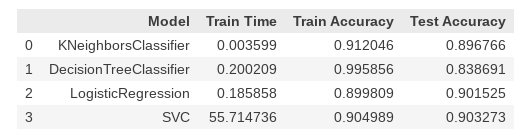

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Feature Importance with Permutation Importance

Using logistic regression as the foundational model, look at feature importance

Should we keep the gender feature?
- There is no gender feature, so that is irrelevant, but I think the result shows that only a handful of the features matter

In [18]:
result = permutation_importance(lgr, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame(
    {
        "Feature": X.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
).sort_values("Importance", ascending=True)
feature_importance

,Feature,Importance,Standard Deviation
11,previous,-0.003689,0.001046
17,nr.employed,-0.001942,0.002127
3,education,-0.001165,0.001288
15,cons.conf.idx,-0.000388,0.001903
8,month,-0.000194,0.003730
5,housing,-0.000194,0.001613
7,contact,0.000583,0.001748
6,loan,0.000583,0.001243
4,default,0.000777,0.001553
10,campaign,0.000971,0.000971


Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

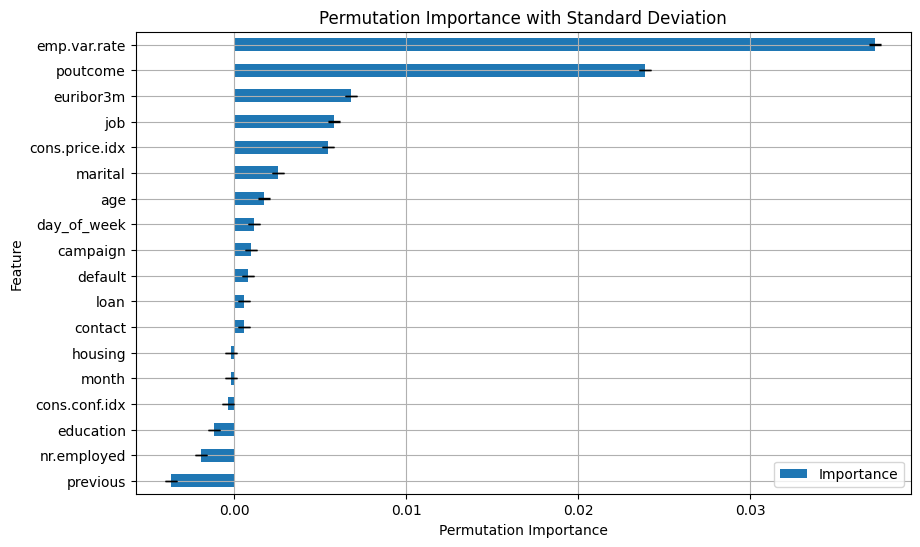

In [19]:
ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    figsize=(10, 6),
    yerr="Standard Deviation",
    capsize=4,
)
ax.set_xlabel("Permutation Importance")
ax.set_title("Permutation Importance with Standard Deviation")

In [20]:
top_5_features = list(feature_importance.tail(5)["Feature"])
top_5_features

['cons.price.idx', 'job', 'euribor3m', 'poutcome', 'emp.var.rate']

In [21]:
results_top_5_df = pd.DataFrame(
    [
        fit_and_time(classifier_name, top_5_features)
        for classifier_name in classifier_names
    ]
)

results_top_5_df

,Model,Train Accuracy,Test Accuracy,Train and Score Time
0,KNeighborsClassifier,0.898964,0.900971,0.115242
1,DecisionTreeClassifier,0.952073,0.875728,0.024444
2,LogisticRegression,0.892487,0.908738,0.020259
3,SVC,0.896373,0.902913,0.051213


#### Adjusting the Performance Metric

The data set is highly imbalanced
- Almost 88% are in the negative class
- So accuracy is not a great measurement
- Switch to f1

In [22]:
scoring = "f1"

#### Hyperparameter Estimation with Grid Search

In [35]:
classifier_params = {
    "KNeighborsClassifier": {
        "param_grid": {
            "classifier__n_neighbors": range(1, 10),
        },
    },
    "DecisionTreeClassifier": {
        "param_grid": {
            "classifier__random_state": [42],
            "classifier__max_depth": range(1, 10),
        },
    },
    "LogisticRegression": {
        "param_grid": {
            "classifier__penalty": ["l1", "l2"],
            "classifier__C": np.logspace(start=-5, stop=5, num=11),
        },
    },
    "SVC": {
        "param_grid": {
            "classifier__kernel": ["rbf", "poly"],
        },
    },
}

In [51]:
def make_scores_dict(estimator, prefix: str, X: pd.DataFrame, y: pd.Series):
    metrics_list = [
        "Accuracy",
        "Balanced Accuracy",
        "Precision",
        "Recall",
        "f1",
        "ROC AUC",
    ]
    y_pred = estimator.predict(X)
    return {
        prefix
        + metric: round(
            eval(metric.lower().replace(" ", "_") + "_score")(y, y_pred) * 100.0,
            2,
        )
        for metric in metrics_list
    }

In [52]:
def grid_search_fit_and_time(
    classifier_name: str = "",
    scoring: str = "",
    features: list = list(X_train.columns),
):
    classifier_pipeline = make_pipeline(classifier_name=classifier_name)

    tic = time()
    grid = GridSearchCV(
        estimator=classifier_pipeline,
        param_grid=classifier_params[classifier_name]["param_grid"],
        scoring=scoring,
        cv=5,
    ).fit(X_train[features], y_train)
    grid_search_time = time() - tic

    tic = time()
    train_scores = make_scores_dict(
        estimator=grid.best_estimator_,
        prefix="Train ",
        X=X_train[features],
        y=y_train,
    )

    test_scores = make_scores_dict(
        estimator=grid.best_estimator_,
        prefix="Test ",
        X=X_test[features],
        y=y_test,
    )
    score_time = time() - tic

    return (
        {
            "Model": classifier_name,
            "Average Fit Time": grid_search_time / len(grid.cv_results_["params"]),
            "Score Time": score_time,
        }
        | train_scores
        | test_scores
        | {
            "Best Params": grid.best_params_,
            "Best Estimator": grid.best_estimator_,
        }
    )

In [53]:
results_gridded_df = pd.DataFrame(
    [
        grid_search_fit_and_time(
            classifier_name=classifier_name,
            scoring="recall",
        )
        for classifier_name in list(classifier_params.keys())
    ]
)

results_gridded_df

,Model,Average Fit Time,Score Time,Train Accuracy,Train Balanced Accuracy,Train Precision,Train Recall,Train f1,Train ROC AUC,Test Accuracy,Test Balanced Accuracy,Test Precision,Test Recall,Test f1,Test ROC AUC,Best Params,Best Estimator
0,KNeighborsClassifier,0.177451,0.197942,100.00,100.00,100.00,100.00,100.00,100.00,86.41,60.60,37.21,27.12,31.37,60.60,{'classifier__n_neighbors': 1},"(ColumnTransformer(remainder=StandardScaler(),..."
1,DecisionTreeClassifier,0.121724,0.029982,93.78,73.86,95.51,48.02,63.91,73.86,89.51,61.62,60.00,25.42,35.71,61.62,"{'classifier__max_depth': 8, 'classifier__rand...","(ColumnTransformer(remainder=StandardScaler(),..."
2,LogisticRegression,0.098837,0.029975,89.44,59.36,62.07,20.34,30.64,59.36,91.07,64.71,78.26,30.51,43.90,64.71,"{'classifier__C': 100.0, 'classifier__penalty'...","(ColumnTransformer(remainder=StandardScaler(),..."
3,SVC,0.436759,0.124624,92.49,67.72,96.92,35.59,52.07,67.72,90.29,59.84,80.00,20.34,32.43,59.84,{'classifier__kernel': 'poly'},"(ColumnTransformer(remainder=StandardScaler(),..."


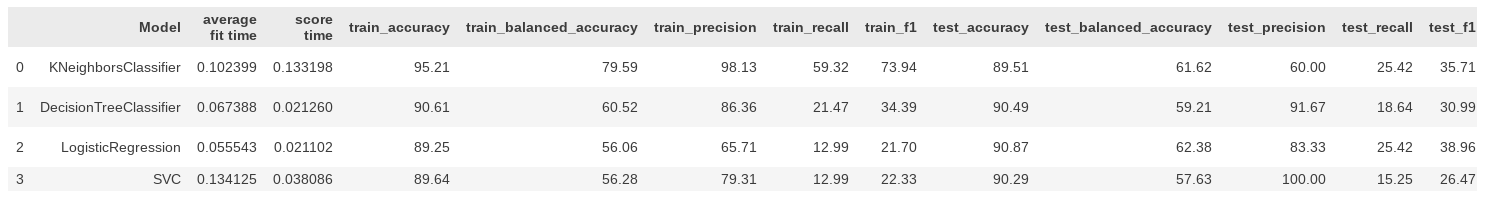

In [38]:
dt = results_top_5_gridded_df.iloc[1, :]["Best Estimator"].named_steps["classifier"]
dt.max_depth
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}